<a href="https://colab.research.google.com/github/BhanuHarshaY/Street-View-House-Numbers-SVHN-Clssification/blob/main/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ASSIGNMENT9 |Street View House Numbers (SVHN) DIGIT CLASSIFICATION|AUTHOR: BHANU HARSHA Y | DT: 11/08/25**


In [54]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time

import warnings
warnings.filterwarnings('ignore')

# I set random seed to 42 for reproducability
np.random.seed(42)
tf.random.set_seed(42)

print("Imported all required libraries!")


Imported all required libraries!


## **Q1) DATA COLLECTION AND UNDERSTANDING THE DATASET:**



**I am using `format 2` which is suggested by professor from dataset [stanford.edu/housenumbers](http://ufldl.stanford.edu/housenumbers/) for this assignment.**

1.  Here we will load the data(images) which are in `.mat format` in to py dictionaries and  read the dataset from the provided input data files **"train_32x32.mat"** & **"test_32x32.mat"** using *SciPy library*. And then basic details like image Dimensions, labels, and image formats will be discussed in the following code block.

2. Make sure that you have already uploaded the files **"train_32x32.mat"** & **"test_32x32.mat"** to the Google Colab environment before running the below cell.


Loading the dataset from train and test files.

DATASET OVERVIEW
Total training samples present: 73257
Training samples (85%): 62268
Validation samples (15%): 10989
Total Testing samples: 26032

Image dimensions: (32, 32, 3) (Height x Width x Channels)
Image format: RGB (3 channels)
Data type: uint8
Pixel value range: [0, 255]

No of classes present: 10
Class labels: [0 1 2 3 4 5 6 7 8 9]


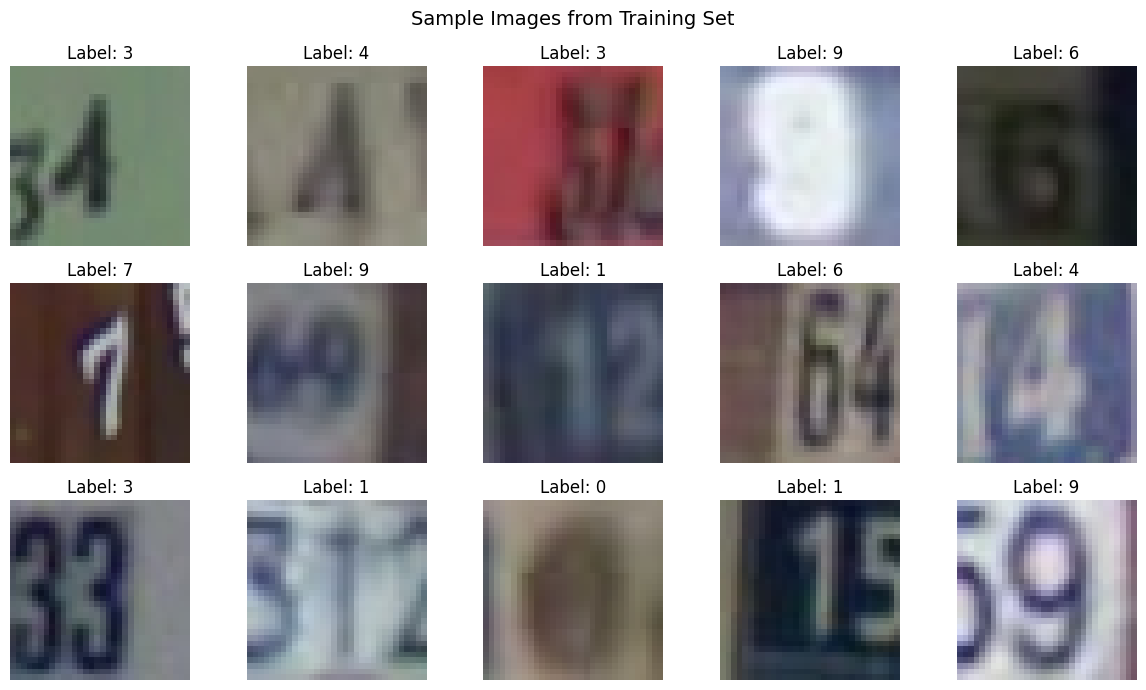

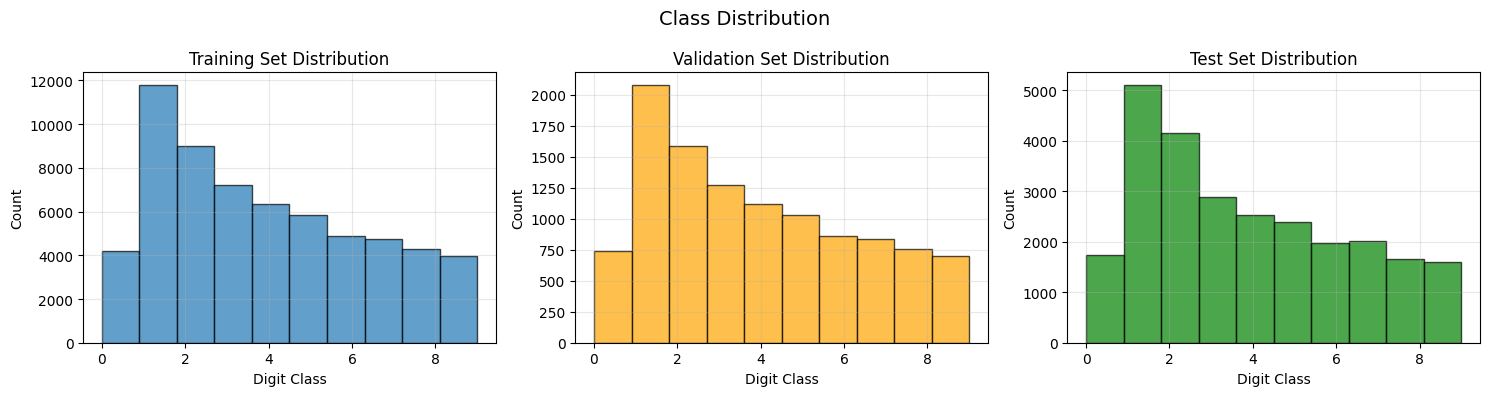

In [55]:
print(f"\nLoading the dataset from train and test files.")
# Load the data from .mat files
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Extracting images into train and test
X_train_full = train_data['X']
y_train_full = train_data['y'].flatten()
X_test = test_data['X']
y_test = test_data['y'].flatten()

# labelling 10 as 0
y_train_full[y_train_full == 10] = 0
y_test[y_test == 10] = 0

# Transposing
X_train_full = np.moveaxis(X_train_full, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

# splitting data for vallidation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15, random_state=42, stratify=y_train_full
)


print("\nDATASET OVERVIEW")
print(f"Total training samples present: {len(X_train_full)}")
print(f"Training samples (85%): {X_train.shape[0]}")
print(f"Validation samples (15%): {X_val.shape[0]}")
print(f"Total Testing samples: {X_test.shape[0]}")
print(f"\nImage dimensions: {X_train.shape[1:4]} (Height x Width x Channels)")
print(f"Image format: RGB (3 channels)")
print(f"Data type: {X_train.dtype}")
print(f"Pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"\nNo of classes present: {len(np.unique(y_train))}")
print(f"Class labels: {np.unique(y_train)}")

# Visualising sample imgs
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.suptitle("Sample Images from Training Set", fontsize=14)
plt.tight_layout()
plt.show()

#Class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(y_train, bins=10, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Digit Class')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_val, bins=10, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Validation Set Distribution')
axes[1].set_xlabel('Digit Class')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

axes[2].hist(y_test, bins=10, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Test Set Distribution')
axes[2].set_xlabel('Digit Class')
axes[2].set_ylabel('Count')
axes[2].grid(True, alpha=0.3)

plt.suptitle("Class Distribution", fontsize=14)
plt.tight_layout()
plt.show()

## **Q1 D&A**
# **Discussion:**

1.   In this initial analysis code, first, I loaded the *SVHN dataset* into `train_data`& `test_data` using ` SciPy`.
2. Did label correction (10 is labelled as 0).
3.   Then I used `np.moveaxis` to *transpose* MATLAB's format **`(Height×Width×Channels×N(samples))`** to TensorFlow's expected format **`(N(samples)×Height×Width×Channels)`**.
4. And then I measured the `class distribution` and visualised it with histogram.
# **Analysis:**
1. **Image Dimensions:** This dataset contains `32×32 RGB images`. Each image represents street house numbers.
2. **Labels:** Dataset contains `digits ranging from 0-9` and `10 is labelled as 0`.
3. **Image format:** Images are present in `.mat` format.
4. **Class distribution:** Classes are `relatively balanced and distributed` which mitigates the risk of bias.
5. **My implication:** After looking at the displayed sample images, as expected, images show variations in lighting, blur and complexity. I `used full dataset` for better model training and accuracy.

---
## **Q2) DATA PRE PROCESSING:**


DATA PRE PROCESSING
Data type after conversion: float32
Normalized pixel range: [0.00, 1.00]

Shape after data preprocessing:
   X_train: (62268, 32, 32, 3)
   y_train : (62268, 10)


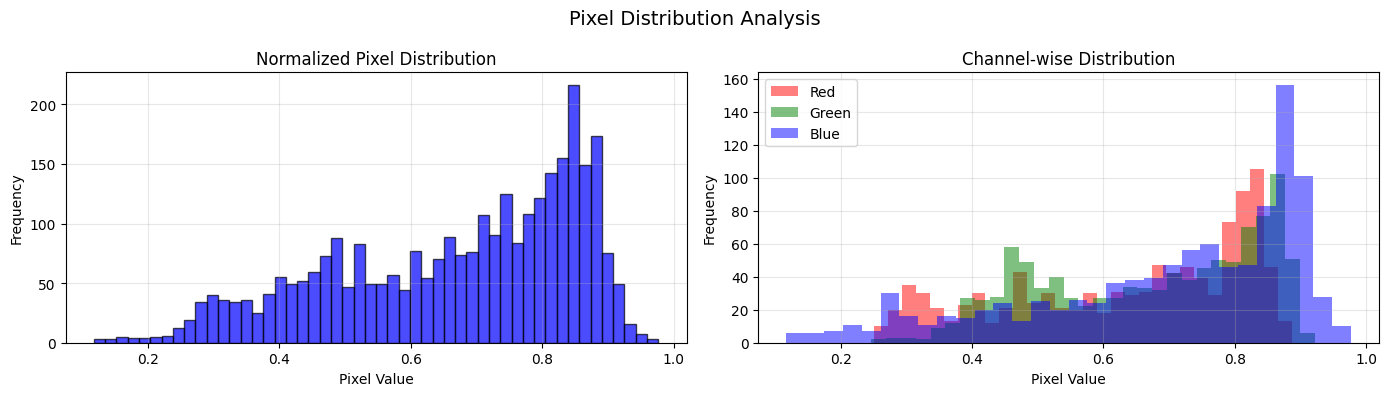

In [56]:
#Data pre processing: cleaning, normalizing, and re-shaping the data for the model input.
print("\nDATA PRE PROCESSING")
# Converting data type to float32 and normalizing pixels
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# one hot encoding
y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

print(f"Data type after conversion: {X_train.dtype}")
print(f"Normalized pixel range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"\nShape after data preprocessing:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train : {y_train_encoded.shape}")


#pixel distribution
sample_idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.hist(X_train[sample_idx].flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Normalized Pixel Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for channel, color, name in zip([0, 1, 2], ['red', 'green', 'blue'], ['Red', 'Green', 'Blue']):
    plt.hist(X_train[sample_idx][:,:,channel].flatten(), bins=30, alpha=0.5, color=color, label=name)
plt.title('Channel-wise Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("Pixel Distribution Analysis", fontsize=14)
plt.tight_layout()
plt.show()

## **Q2 D&A**
# **Discussion:**

1. In this code cell `essential data pre-processing` like cleaning, transformation were performed.
2. I `transformed raw pixel values` data type into `float32` which is suitable for neural network training.
3.   Then I  `normalized` pixel values by `dividing by 255`.
4. Labels were one hot encoded using `to_categorical` to create binary vectors.
5. And then I `visualised` normalised pixel values using `histogram`.
# **Analysis:**
1. **Cleaning:** Data type is converted from `unit8` to `float32` which is optimal for neural network training.
2. **Transformation:** I performed `one hot encoding` on labels using `to_categorical` for converting them into `binary matrices` enabling `categorical cross entropy loss` in models.
3. **Normalization:** Did pixel normalization by `/255`, which scales values`[0,255]` to `[0,1]`.
4. **Effect on dataset:** `X_train` shape remains ` (62,268, 32, 32, 3)` but with scaled values, improving model input consistency; `y_train` labels `expand` to `(62,268, 10)` **boosting model training efficiency**.
5. **Visualisation:** From the plotted `histogram`, we can confirm that `normalization is succesful` and `pixels were distributed` across `[0, 1]`. And the spread is `non-skewed`.

---
## **Q3) DATA AGUMENTATION:**


DATA AGUMENTATION:
Augmentation approach applied:
  Rotation: ±15 deg
  Translation: ±10% horizontal/vertical
  Zoom: ±15%
  Fill mode: nearest
  Horizontal flip: False


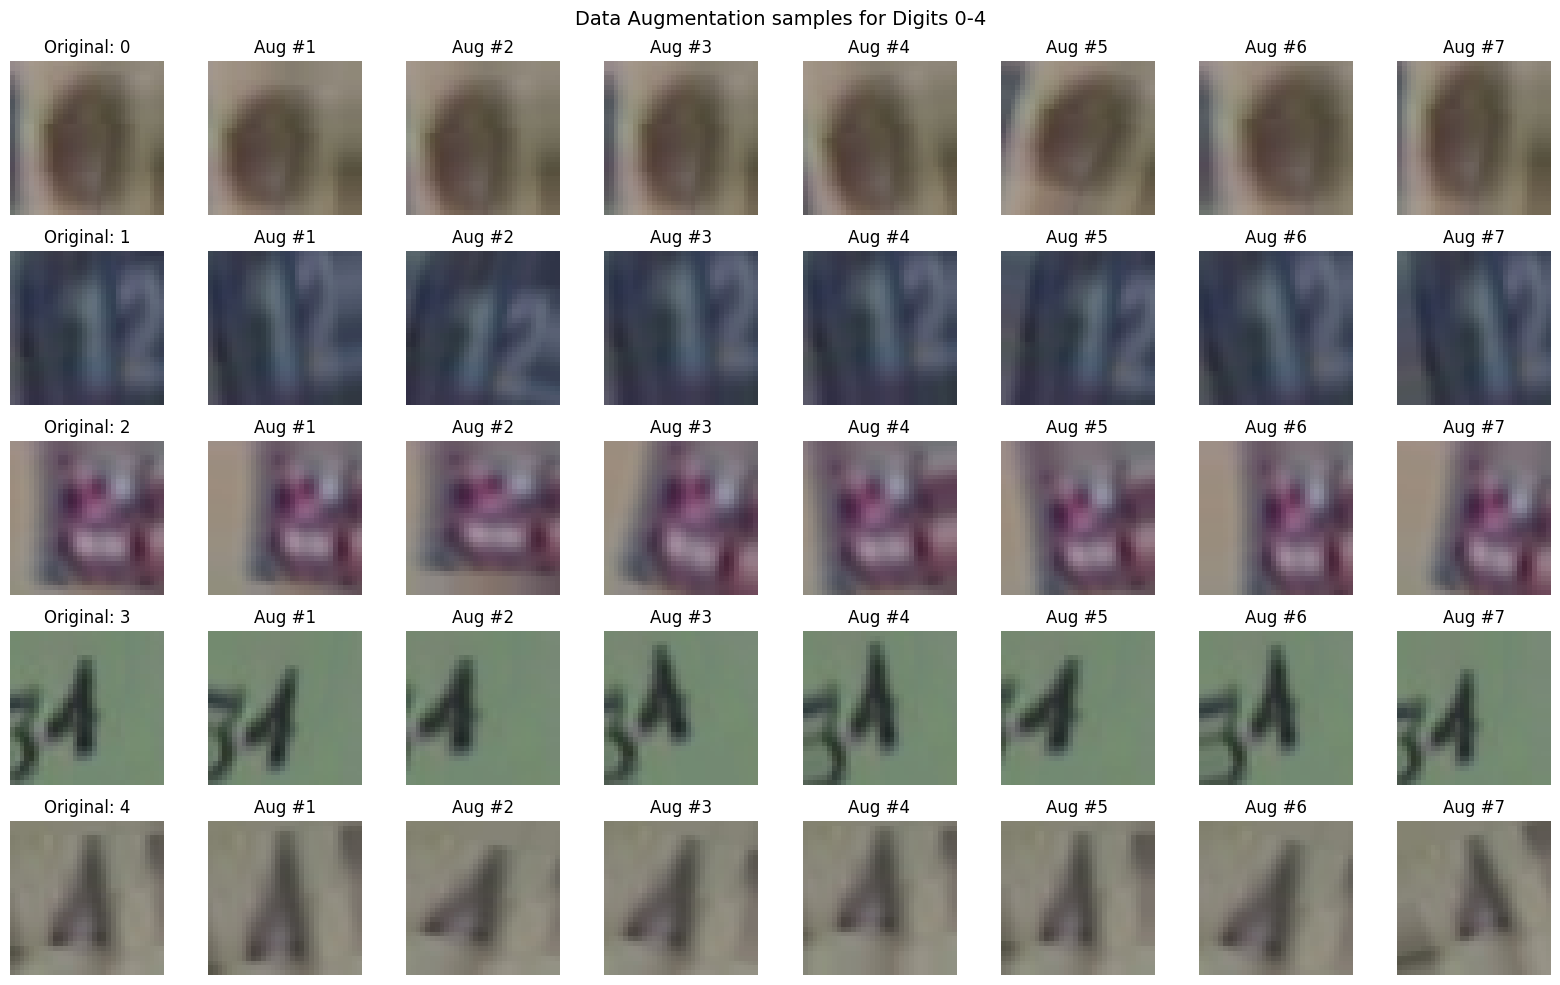

In [66]:
# Data Augmentation Process
print("\nDATA AGUMENTATION:")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=False

)

# Fitting the training data
datagen.fit(X_train)

print("Augmentation approach applied:")
print("  Rotation: ±15 deg")
print("  Translation: ±10% horizontal/vertical")
print("  Zoom: ±15%")
print("  Fill mode: nearest")
print("  Horizontal flip: False")

# Demonstration
fig, axes = plt.subplots(5, 8, figsize=(16, 10))

for digit in range(5):
    digit_indices = np.where(y_train == digit)[0]
    if len(digit_indices) > 0:
        sample_idx = digit_indices[0]

        # Original image
        axes[digit, 0].imshow(X_train[sample_idx])
        axes[digit, 0].set_title(f"Original: {digit}")
        axes[digit, 0].axis('off')

        sample_batch = X_train[sample_idx:sample_idx+1]
        # Agumented images
        for j in range(1, 8):
            flow = datagen.flow(sample_batch, batch_size=1, shuffle=False)
            augmented_batch = next(flow)
            augmented_image = augmented_batch[0]

            axes[digit, j].imshow(augmented_image)
            axes[digit, j].set_title(f"Aug #{j}")
            axes[digit, j].axis('off')

plt.suptitle("Data Augmentation samples for Digits 0-4", fontsize=14)
plt.tight_layout()
plt.show()

## **Q3 D&A**
# **Discussion:**

**Data Agumentation:**  `DATA AGUMENTATION` is a crucial task that need to be performed model training, which `increases model generalization` and mitigate the `risk of overfittiing`. It artficially expands or diminishes image's rotation, horizontal shift, vertical shift, zoom, brightness etc. I implemented data agumentation here using `ImageDataGenerator` from `Keras`.
# **Analysis:**
1. The methods that I implemented were *Rotation(±15 degrees),  Translation(±10% horizontal/vertical shift), Zoom(±15%), Fill mode(nearest), horizontal_flip(False)*.
2. I set ` horizontal_flip=False` so the didgits are preserved as horizontal digits make no sense.
3. digits(0-4) were visualised before and after augmentation.
4. `First Column` represents `original images`.
5. Subsequent columns represents `7 unique randomly transformed` versions.
6. For instance you can observe that `Aug#4` is visibly rotated compared to `Aug#3`.

---
## **Q4) DATA BATCHING:**

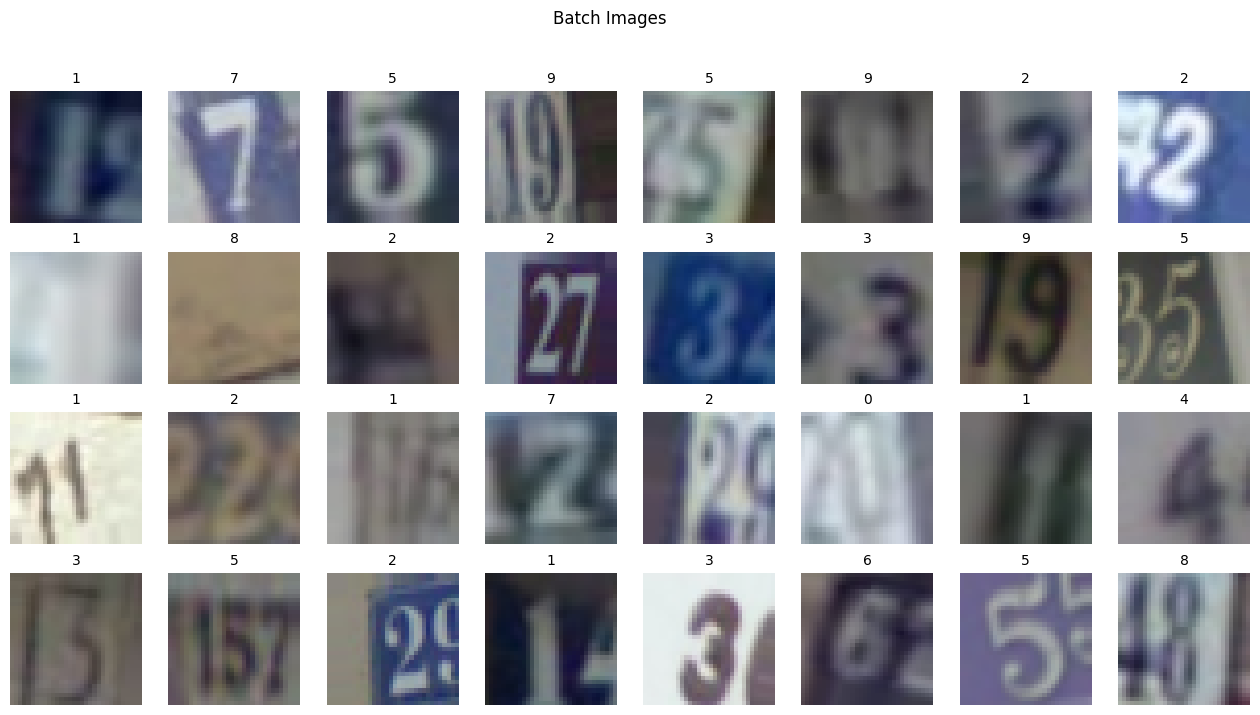

Batch size: 128
Steps per epoch: 486


In [67]:
# Batching
BATCH_SIZE = 128

# generators
train_gen = datagen.flow(X_train, y_train_encoded, batch_size=BATCH_SIZE,shuffle=True )
val_gen = ImageDataGenerator().flow(X_val, y_val_encoded, batch_size=BATCH_SIZE, shuffle=False)

steps_per_epoch = len(X_train) // BATCH_SIZE
val_steps = len(X_val) // BATCH_SIZE

# batch imgs display
batch_x, batch_y = next(train_gen)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < 32:
        ax.imshow(batch_x[i])
        ax.set_title(f"{np.argmax(batch_y[i])}", fontsize=10)
        ax.axis('off')
plt.suptitle("Batch Images")
plt.show()

print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {steps_per_epoch}")